In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


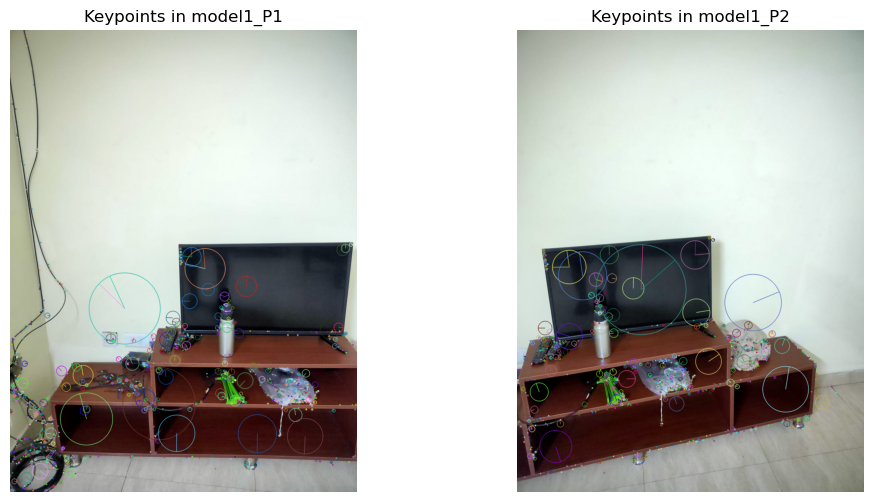

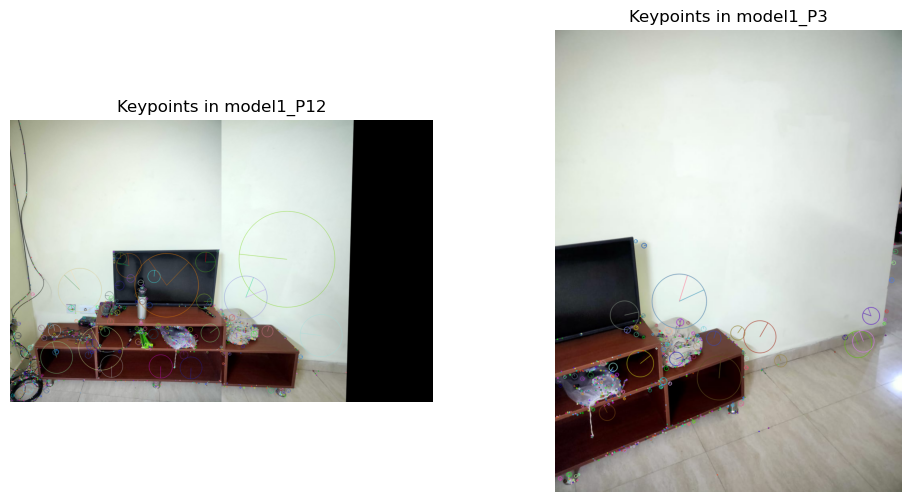

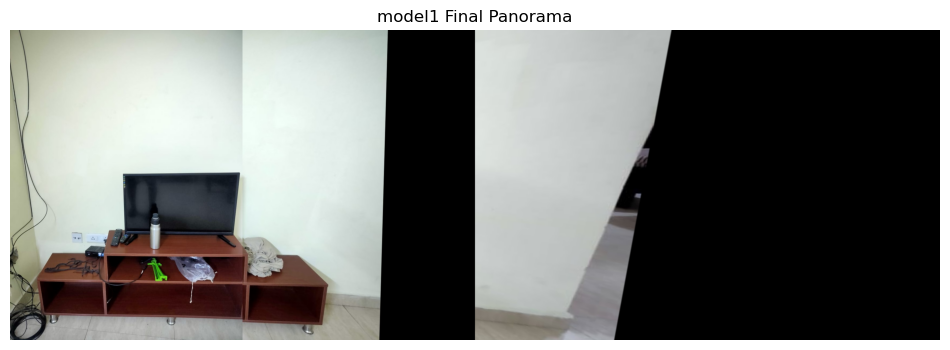

In [13]:
def detect_and_match_keypoints(img1, img2):
    """Detect keypoints using SIFT and match features between two images."""
    sift = cv2.SIFT_create()
    
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Feature Matching using BFMatcher (Brute Force Matcher with KNN)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Draw keypoints on images
    img1_keypoints = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_keypoints = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return keypoints1, keypoints2, good_matches, img1_keypoints, img2_keypoints

def stitch_images(img1, img2):
    """Find homography and stitch two images together."""
    keypoints1, keypoints2, good_matches, img1_kp, img2_kp = detect_and_match_keypoints(img1, img2)
    
    # Extract location of matched keypoints
    if len(good_matches) > 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute homography
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        # Warp img2 to img1's perspective
        height, width, _ = img1.shape
        warped_img2 = cv2.warpPerspective(img2, H, (width * 2, height))  # Increase width to avoid cutoff

        # Blend the images together
        stitched_img = warped_img2.copy()
        stitched_img[0:height, 0:width] = img1

        return stitched_img, img1_kp, img2_kp
    else:
        print("Not enough matches found!")
        return None, None, None

# Load images
img1 = cv2.imread("P1.jpg")
img2 = cv2.imread("P2.jpg")
img3 = cv2.imread("P3.jpg")

# Stitch P1 and P2
stitched_P12, kp1, kp2 = stitch_images(img1, img2)
cv2.imwrite("model1_stitched_P12.jpg", stitched_P12)

# Save keypoints images for P1 and P2
cv2.imwrite("model1_P1_keypoints.jpg", kp1)
cv2.imwrite("model1_P2_keypoints.jpg", kp2)

# Display keypoints for P1 and P2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(kp1, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in model1_P1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(kp2, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in model1_P2")
plt.axis("off")
plt.show()

# Load stitched image P12
img_P12 = cv2.imread("model1_stitched_P12.jpg")

# Stitch P12 and P3
final_panorama, kp12, kp3 = stitch_images(img_P12, img3)

# Save keypoints images for P12 and P3
cv2.imwrite("model1_P12_keypoints.jpg", kp12)
cv2.imwrite("model1_P3_keypoints.jpg", kp3)

# Save the final panorama
cv2.imwrite("model1_final_panorama.jpg", final_panorama)

# Display keypoints for P12 and P3
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(kp12, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in model1_P12")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(kp3, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in model1_P3")
plt.axis("off")
plt.show()

# Display final panorama
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
plt.title("model1 Final Panorama")
plt.axis("off")
plt.show()


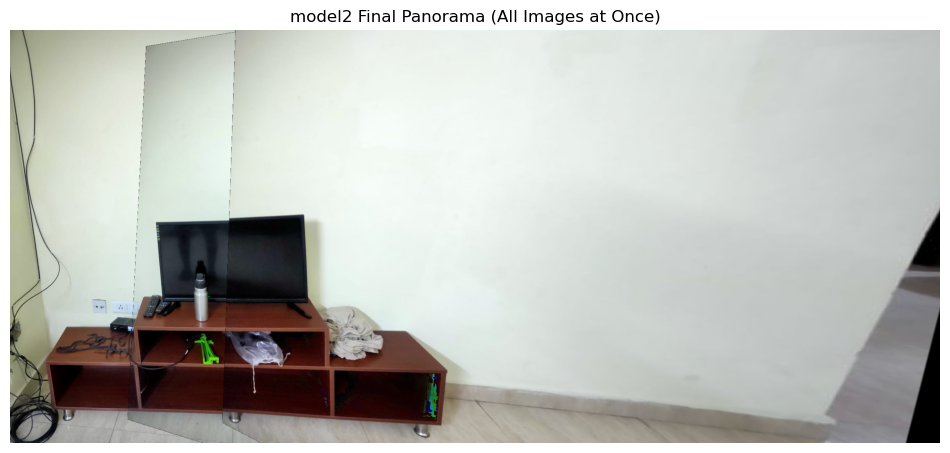

In [15]:
def detect_and_match_keypoints(img1, img2):
    """Detect keypoints using SIFT and match features between two images."""
    sift = cv2.SIFT_create()

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Feature Matching using BFMatcher (Brute Force Matcher with KNN)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    return keypoints1, keypoints2, good_matches

def compute_homography(img1, img2, img1_name, img2_name):
    """Find homography between two images using matched keypoints."""
    keypoints1, keypoints2, good_matches = detect_and_match_keypoints(img1, img2)

    if len(good_matches) > 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute homography using RANSAC
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        # Save matched keypoints visualization
        match_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.imwrite(f"model2_{img1_name}_to_{img2_name}_matches.jpg", match_img)

        return H
    else:
        print(f"Not enough matches found between {img1_name} and {img2_name}!")
        return None

def stitch_images(images, image_names):
    """Stitch multiple images together using homography transformations."""
    base_img = images[0]  # First image as reference
    result = base_img.copy()
    
    # Set final panorama size (increase width to prevent cutoff)
    height, width, _ = base_img.shape
    panorama = cv2.warpPerspective(base_img, np.eye(3), (width * 3, height))

    cv2.imwrite("model2_base_image.jpg", base_img)

    for i in range(1, len(images)):
        H = compute_homography(base_img, images[i], image_names[0], image_names[i])
        
        if H is None:
            print(f"Skipping image {i+1} due to insufficient matches.")
            continue

        # Warp the next image into the panorama
        warped_img = cv2.warpPerspective(images[i], H, (width * 3, height))

        # Save each intermediate warp result
        cv2.imwrite(f"model2_warped_{image_names[i]}.jpg", warped_img)

        # Blend the images by overlaying non-black pixels
        panorama = np.where(warped_img > 0, warped_img, panorama)

    return panorama

# Load images
img1 = cv2.imread("P1.jpg")
img2 = cv2.imread("P2.jpg")
img3 = cv2.imread("P3.jpg")

# Stitch all images at once
final_panorama = stitch_images([img1, img2, img3], ["P1", "P2", "P3"])

# Save the final panorama
cv2.imwrite("model2_final_panorama.jpg", final_panorama)

# Display final panorama
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
plt.title("model2 Final Panorama (All Images at Once)")
plt.axis("off")
plt.show()


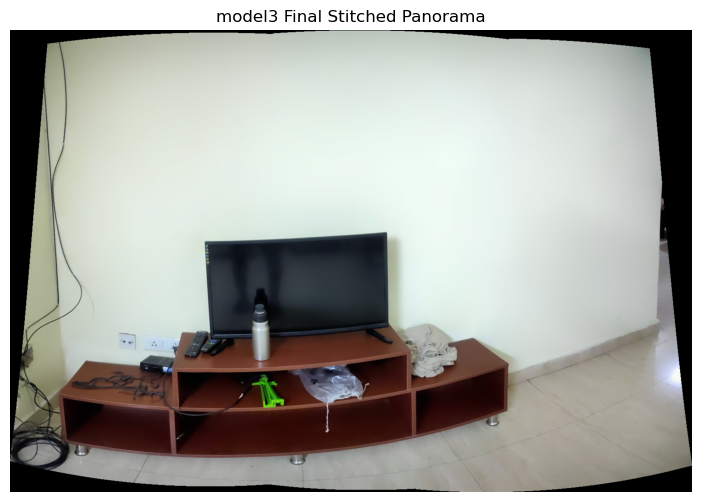

In [17]:
img1 = cv2.imread('P1.jpg')
img2 = cv2.imread('P2.jpg')
img3 = cv2.imread('P3.jpg')

# Initialize OpenCV's Stitcher
stitcher = cv2.Stitcher.create()
status, panorama = stitcher.stitch([img1, img2, img3])

# Save and display result
cv2.imwrite("model3_final_panorama.jpg", panorama)

# Show panorama using Matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis("off")
plt.title("model3 Final Stitched Panorama")
plt.show()
